# Cold Start Analysis

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import SVD
from tqdm import tqdm


import os
import sys
sys.path.append("..")

from modules.filters.rule_based import RuleBasedFiltering
from modules.filters.content_based import ContentBasedFiltering
from modules.filters.collaborative import CollaborativeFiltering
from app import load_dataset, partition_data

### Task 4: Tackle the Cold Start Problem (50pts)

Create a notebook notebooks/cold_start_analysis.ipynb to simulate and analyze the cold start scenario. The notebook must:

* In a markdown cell, explain and offer three valid alternative strategies to mitigate cold starts. 
* Simulate scenarios where a new user has rated no or a few (i.e., 1, 2, 3, etc.) movies.
* Provide performance analysis and visualizations for each alternative strategies of cold start scenarios.
    * In a markdown cell, explain how your results would impact your design decisions when faced with the cold start problem.
* Detail how your observations would influence your design.


In [2]:
# Gloal variables
STORAGE_DIR = '../storage/'

# Source Data Paths
ratings_data_path = os.path.join(STORAGE_DIR, 'u.data')
item_data_path = os.path.join(STORAGE_DIR, 'u.item') 
user_data_path = os.path.join(STORAGE_DIR, 'u.user')
genre_data_path = os.path.join(STORAGE_DIR, 'u.genre')
occupation_data_path = os.path.join(STORAGE_DIR, 'u.occupation')

# Data Partition Paths
train_data_path = os.path.join(STORAGE_DIR, 'train')
test_data_path = os.path.join(STORAGE_DIR, 'test')

#### Cold Start Mitigation - Hybrid Recommendation System 

In general, we need to combine Collaborative Filtering (CF), Content-based Filtering (CBF) and Rule-based Filtering (RBF) to fill the gaps of cold starts.
1. Rule-based: Recommend the top-rated items among the users or in a specific domain.
    * By item metadata, such as genre, recency, etc
    * By user metadata, such as gender, occupation, etc.
2. Content-based: Recommend using content similarities (e.g. metadata, embeddings) until enough ratings accumulate.
3. Once enough data collected for user-item interactions, the CF model can be put to product for more accurate recommendation.


#### Cold Start Users

In [3]:
# Load Datasets
data_path = os.path.join(ratings_data_path)
ratings = load_dataset(data_path, separation_type="\t")
ratings.columns = ["user", "item", "rating", "timestamp"]
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

print(f"Ratings dataset shape: {ratings.shape}")
display(ratings.head())

Ratings dataset shape: (100000, 4)


,user,item,rating,timestamp
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16


For this case, **user stratified partitioning** will be used to split train and test datasets. Thus we can test recommenders on cold start users and items.

In [4]:
# Partition Data by user-stratified split
train_df, test_df = partition_data(ratings, split=.5, partition_type='stratified', stratify_by='user')
print(f"Train dataset shape: {train_df.shape}")
print(f"Test dataset shape: {test_df.shape}")

# Cold start users
train_users = set(train_df['user'].unique())
test_users = set(test_df['user'].unique())
assert train_users.isdisjoint(test_users), "Users overlap between train and test datasets!" 
cold_users = test_users - train_users   # cold_users = test_users, since no overlap from train_users
print(f"{len(cold_users)} cold start users out of {len(test_users)} in test set.")


# Save the train and test datasets
train_df.to_csv(train_data_path, sep='\t', header=False, index=False)
test_df.to_csv(test_data_path, sep='\t', header=False, index=False)

Train dataset shape: (49929, 4)
Test dataset shape: (50071, 4)
472 cold start users out of 472 in test set.


Thus we established the test case for cold-start users. 

Note that warm-start items are not filtered out from test set, as we are focusing on the predictions for new users.

#### Performance Evaluation 
* Evaluate each model using RMSE/MAE, and nDCG on the test set.
* Visualize performance comparisons and an explanation of the results.

In [5]:
genders = ['F', 'M']
genre_df = pd.read_csv(genre_data_path, sep='|', header=None, names=['genre', 'id'])
occupation_df = pd.read_csv(occupation_data_path, sep='|', header=None, names=['occupation'])

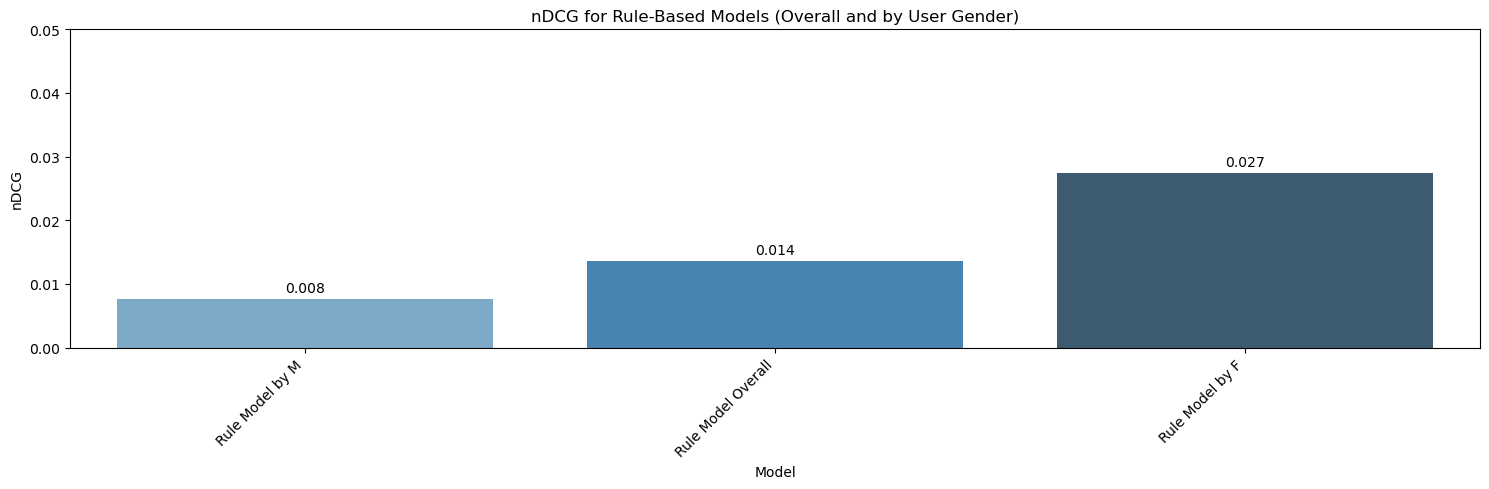

In [6]:
# Rule-Based Filtering (Non personalized recommendations)
performance = []
rule_model = RuleBasedFiltering(train_data_path, item_data_path, user_data_path)

# Recommend top-rated movies overall
recommend_overall = rule_model.recommend(k=5, rule='overall')  
performance.append({
    'Model': 'Rule Model Overall',
    'Metric': 'nDCG',
    'Value': rule_model.evaluate(recommend_overall, test_df)
})

# Recommend top-rated movies by user's gender
for gender in genders:
    recommend_gender = rule_model.recommend(k=5, rule='by_gender', criteria=gender)
    performance.append({
        'Model': f'Rule Model by {gender}',
        'Metric': 'nDCG',
        'Value': rule_model.evaluate(recommend_gender, test_df)
    })    

# Visualize the performance
ndcg_df = pd.DataFrame(performance).sort_values(by='Value', ascending=True)

plt.figure(figsize=(15, 5))
ax = sns.barplot(data=ndcg_df, x='Model', y='Value', hue='Model', palette='Blues_d')

plt.title("nDCG for Rule-Based Models (Overall and by User Gender)")
plt.ylabel("nDCG")
plt.ylim(0, max(ndcg_df['Value'].max() * 1.3, 0.05))
plt.xticks(rotation=45, ha='right')
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3) # Add labels with formatting and padding

plt.tight_layout()
plt.show() 

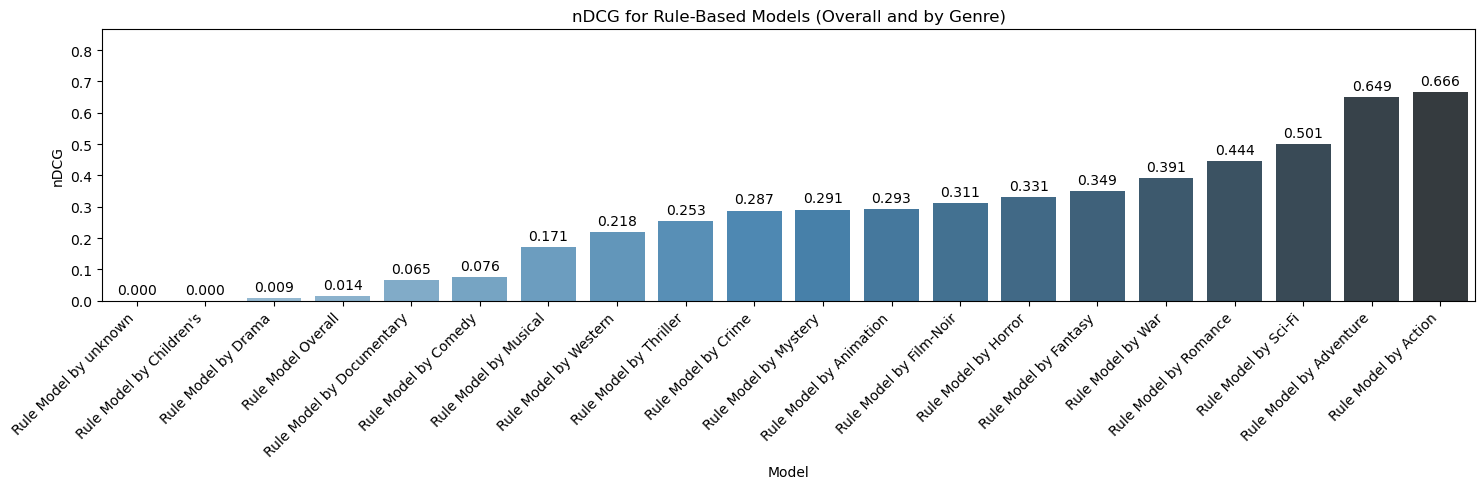

In [7]:
performance = []
performance.append({
    'Model': 'Rule Model Overall',
    'Metric': 'nDCG',
    'Value': rule_model.evaluate(recommend_overall, test_df)
})

# Recommend top-rated movies by genre
for genre in genre_df['genre'].tolist():
    recommend_genre = rule_model.recommend(k=5, rule='by_genre', criteria=genre)  
    performance.append({
        'Model': f'Rule Model by {genre}',
        'Metric': 'nDCG',
        'Value': rule_model.evaluate(recommend_genre, test_df)
    })

# Visualize the performance
ndcg_df = pd.DataFrame(performance).sort_values(by='Value', ascending=True)

plt.figure(figsize=(15, 5))
ax = sns.barplot(data=ndcg_df, x='Model', y='Value', hue='Model', palette='Blues_d')

plt.title("nDCG for Rule-Based Models (Overall and by Genre)")
plt.ylabel("nDCG")
plt.ylim(0, max(ndcg_df['Value'].max() * 1.3, 0.05))
plt.xticks(rotation=45, ha='right')
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3) # Add labels with formatting and padding

plt.tight_layout()
plt.show()

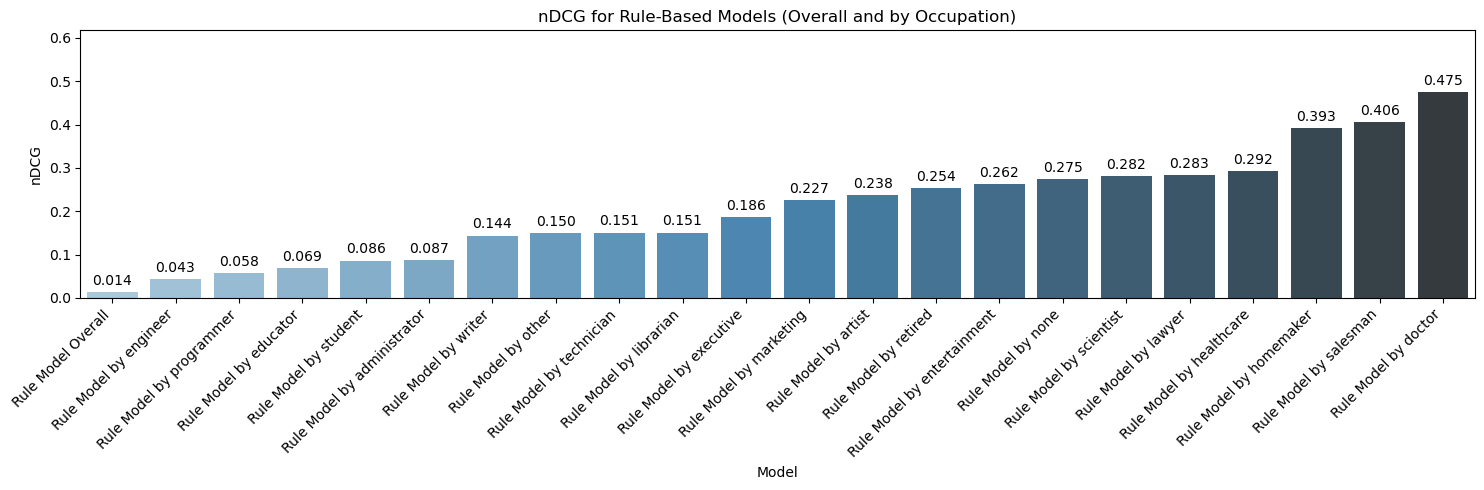

In [8]:
performance = []
performance.append({
    'Model': 'Rule Model Overall',
    'Metric': 'nDCG',
    'Value': rule_model.evaluate(recommend_overall, test_df)
})

# Recommend top-rated movies by occupation
for occupation in occupation_df['occupation'].tolist():
    recommend_occupation = rule_model.recommend(k=5, rule='by_occupation', criteria=occupation)  # top-rated movies by occupation
    performance.append({
        'Model': f'Rule Model by {occupation}',
        'Metric': 'nDCG',
        'Value': rule_model.evaluate(recommend_occupation, test_df)
    })

# Visualize the performance
ndcg_df = pd.DataFrame(performance).sort_values(by='Value', ascending=True)

plt.figure(figsize=(15, 5))
ax = sns.barplot(data=ndcg_df, x='Model', y='Value', hue='Model', palette='Blues_d')

plt.title("nDCG for Rule-Based Models (Overall and by Occupation)")
plt.ylabel("nDCG")
plt.ylim(0, max(ndcg_df['Value'].max() * 1.3, 0.05))
plt.xticks(rotation=45, ha='right')
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3) # Add labels with formatting and padding

plt.tight_layout()
plt.show()

#### Performance Analysis (Part I)
**Rule-based Filtering**
* Best performance: top-rated Action movies (nDCG = 0.666) and Adventure movies (nDCG = 0.649), indicating that the action and adventure genre are highly aligned with user preferences.
* Moderate performance (nDCG >= 0.4): top-rated Sci-Fi movies, Romance movies, or the ones by Doctor and Salesman, suggesting these rules are somewhat predictive.
* Particularly, the recommendation by user gender is not effective.
* In general, the rule-based recommendation is not personalized and thus can be used for cold start cases. However, the domain-based recommendations (as the rules of top and moderate performers) can be more effective than general ones.


In [9]:
# Content-Based Filtering for cold start users
content_model = ContentBasedFiltering(train_data_path, item_data_path)

# Collaborative Filtering for cold start users
svd_params = {'n_factors': 200, 'n_epochs': 100, 'lr_all': 0.01, 'reg_all': 0.1}
collaborative_model = CollaborativeFiltering(
    data_path, 
    item_data_path, 
    SVD(**svd_params),
    trainset_df=train_df,
    validset_df=test_df)
collaborative_model.fit()

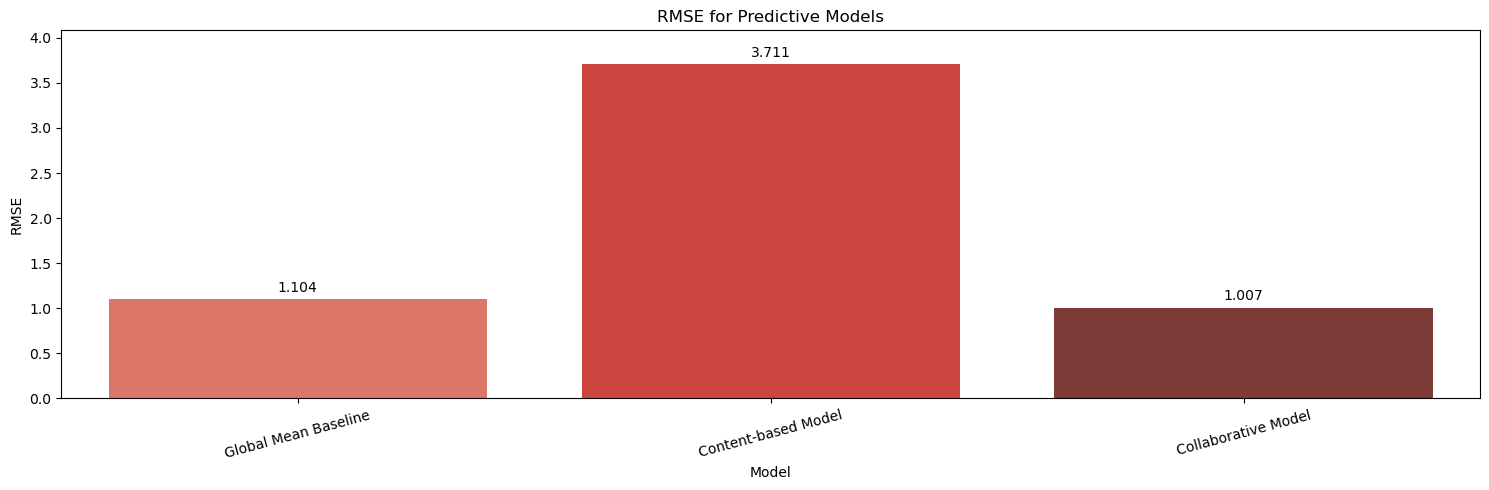

In [10]:
# Evaluation for Prediction Models
performance = []
performance.append({
    'Model': 'Global Mean Baseline',
    'Metric': 'RMSE',
    'Value': np.sqrt(np.mean((test_df['rating'] - train_df['rating'].mean()) ** 2))
}) # Global mean as baseline

performance.append({
    'Model': 'Content-based Model',
    'Metric': 'RMSE',
    'Value': content_model.evaluate(validset_df=test_df)
})

performance.append({
    'Model': 'Collaborative Model',
    'Metric': 'RMSE',
    'Value': collaborative_model.evaluate()
})

# Visualize
rmse_df = pd.DataFrame(performance)

plt.figure(figsize=(15, 5))
ax = sns.barplot(data=rmse_df, x='Model', y='Value',  hue='Model', palette='Reds_d')
plt.title("RMSE for Predictive Models")
plt.ylabel("RMSE")
plt.ylim(0, max(rmse_df['Value'].max() * 1.1, 2.2))
plt.xticks(rotation=15)
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3) 
plt.tight_layout()
plt.show()

#### Performance Analysis (Part II)
**Global Mean Baseline**
* It predicts the same value (mean rating) for all users and items, setting up the baseline for CBF and CF predictions.

**Content-based Filtering**
* This model poorly performs with cold-start cases, given the much higher RMSE (~3.7). 
* This is primarily due to cold start users. The current implementation explicitly raises `ValueError` exceptions for missing users or items and does not have a fallback mechanism to use similar items.
* Thus it doesn't handle the "cold start" problem or provide recommendations for users with no rating history.

**Collaborative Filtering**
* Typically collaborative filtering will be affected by cold-start users, as it cannot use user factors. 
* But the items are warm in this case, so SVD has well-learned item bias $b_i$ and likely defaults to
    $ r_{ui} \approx \mu + b_i $, where $\mu$ is the global mean from training dataset.

* Given that, the SVD model is effectively bias-based recommender (item bias + global mean). Not CF in a traditional sense.
* This model beats the baseline, which indicates that item-level patterns are being captured even without user data.

#### Switching to Collabrative Filtering
In this section, we will investigate and decide on the optimal number of user ratings before switching from a cold-start strategy to collaborative filtering (CF) is a critical tuning step for any recommender system. 

Methodology:

1. Isolate "Warm" Users: From the dataset, select a group of users who have a high number of ratings (e.g., more than 50 ratings each).
2. Simulate the Onboarding Process: For each of these users, pretend we only have their first N ratings.
3. Train and Test:
    * Use the first N ratings to run the collaborative filtering algorithm.
    * Predict the user's ratings for the items they rated from N+1 onwards (the "holdout set").
4. Measure Performance: Calculate an accuracy metric (RMSE) for these predictions.
5. Iterate and Plot: Repeat this process for different values of N (e.g., N = 1, 2, 3, ...). Plot the evaluation metric against N.

In [11]:
 # Identify "warm" users (more than 50 ratings)
user_counts = ratings['user'].value_counts()
warm_users = user_counts[user_counts >= 50].index # minimum 50 ratings
print(f"Found {len(warm_users)} 'warm' users for evaluation.")

# Evaluate RMSE for warm users with ratings from N=1 to N=10, 
# simulating a scenario where we only have the user's first N ratings.
avg_rmse_per_n = {}
max_n = 50

for n in range(1, max_n + 1, 5):
    n_rmses = []

    for user in tqdm(warm_users, desc=f"N={n}"):
        # Sort user's ratings by time to get their first N interactions
        warm_user_ratings = ratings[ratings['user'] == user].sort_values('timestamp')
        
        # Split data: first N for training, rest for testing
        train_ratings = warm_user_ratings.head(n)
        test_ratings = warm_user_ratings.iloc[n:]

        if test_ratings.empty:
            continue
        
        # The CF model should be trained on more than one user's data.
        # Other users' ratings are needed to train the model effectively.
        other_users_ratings = ratings[~ratings['user'].isin([user])].sample(n=5000, random_state=42)
        # Combine the current user's ratings with other users' ratings
        combined_train_ratings = pd.concat([train_ratings, other_users_ratings])

        # Initialize and evaluate the Collaborative Filtering model
        cf_model = CollaborativeFiltering(
            data_path, 
            item_data_path, 
            SVD(**svd_params),
            trainset_df=combined_train_ratings,
            validset_df=test_ratings)
        cf_model.fit()
        rmse = cf_model.evaluate()
        n_rmses.append(rmse)
    
    if n_rmses:
        avg_rmse_per_n[n] = np.mean(n_rmses)
        print(f"Average RMSE for N={n}: {avg_rmse_per_n[n]:.4f}")

Found 568 'warm' users for evaluation.


N=1: 100%|██████████| 568/568 [02:21<00:00,  4.02it/s]


Average RMSE for N=1: 1.0524


N=6: 100%|██████████| 568/568 [16:11<00:00,  1.71s/it]   


Average RMSE for N=6: 1.0470


N=11: 100%|██████████| 568/568 [22:25<00:00,  2.37s/it]   


Average RMSE for N=11: 1.0426


N=16: 100%|██████████| 568/568 [30:29<00:00,  3.22s/it]    


Average RMSE for N=16: 1.0351


N=21: 100%|██████████| 568/568 [17:17<00:00,  1.83s/it]   


Average RMSE for N=21: 1.0282


N=26: 100%|██████████| 568/568 [17:39<00:00,  1.86s/it]   


Average RMSE for N=26: 1.0224


N=31: 100%|██████████| 568/568 [11:52<00:00,  1.25s/it]    


Average RMSE for N=31: 1.0184


N=36: 100%|██████████| 568/568 [05:26<00:00,  1.74it/s]


Average RMSE for N=36: 1.0133


N=41: 100%|██████████| 568/568 [17:19<00:00,  1.83s/it]    


Average RMSE for N=41: 1.0125


N=46: 100%|██████████| 568/568 [34:47<00:00,  3.67s/it]    

Average RMSE for N=46: 1.0089


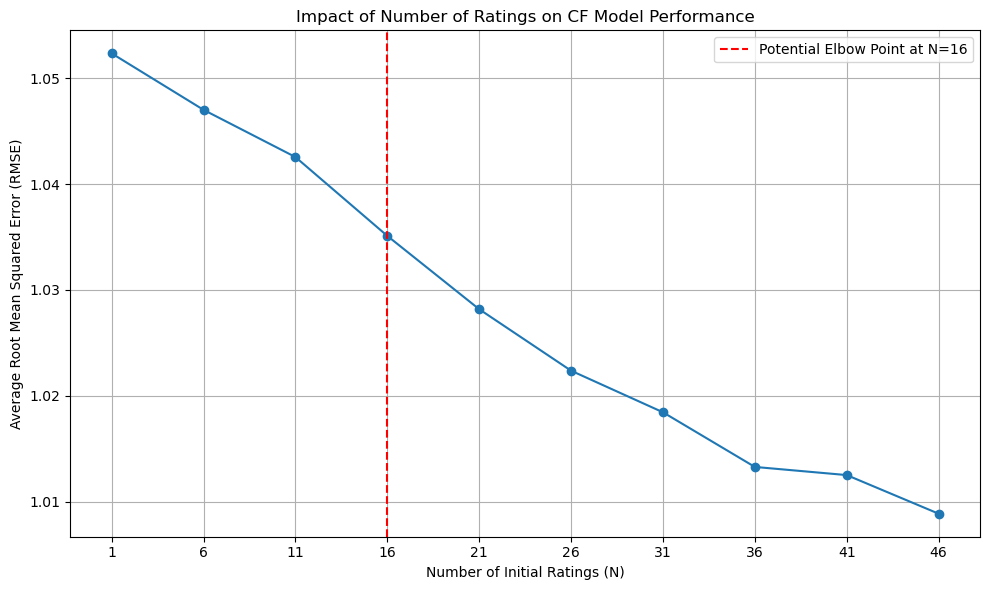

In [12]:
n_values = list(avg_rmse_per_n.keys())
rmse_values = list(avg_rmse_per_n.values())

plt.figure(figsize=(10, 6))
plt.plot(n_values, rmse_values, marker='o', linestyle='-')
plt.title('Impact of Number of Ratings on CF Model Performance')
plt.xlabel('Number of Initial Ratings (N)')
plt.ylabel('Average Root Mean Squared Error (RMSE)')
plt.xticks(n_values)
plt.grid(True)

# Highlight the elbow point (a simple way to estimate it)
try:
    # Find the point with the biggest drop from the previous point
    improvements = [rmse_values[i-1] - rmse_values[i] for i in range(1, len(rmse_values))]
    elbow_index = np.argmax(improvements) + 1
    plt.axvline(x=n_values[elbow_index], color='r', linestyle='--', label=f'Potential Elbow Point at N={n_values[elbow_index]}')
    plt.legend()
except (ValueError, IndexError):
    print("Could not determine elbow point.")

plt.tight_layout()
plt.show()

From the chart above, we can find that when N=16, the CF model makes the biggest improvement from the previous iteration.
Thus, it's suggested to switch to collaborative filtering once the user placed more than 16 ratings.

#### System Design

For **cold-start users**, **rule-based filtering** is a practical approach since it does not depend on prior user interaction history.

* Compared to generic recommendations based on overall top-rated movies, **domain-specific rules** tend to be more effective. These can leverage movie metadata (e.g., top-rated Action or Adventure films) or user profile attributes (e.g., top-rated movies favored by doctors, salespeople, or homemakers).
* More personalized recommendations can be achieved by collecting user preferences during onboarding (e.g., asking users to choose their favorite genres). These preferences can be used to initialize a tailored rule-based recommender (e.g., recommending movies aligned with the user's selected genres).

The **content-based filtering (CBF)** approach is negatively impacted by cold-start scenarios, particularly for users.

* The current implementation relies on both `user_id` and `item_id` being known, which limits its effectiveness when new users or items are introduced.
* To handle cold-start items, an item profile can be constructed using its metadata, and a similarity score can be computed (e.g., cosine similarity) against the user's profile. This allows recommendations for new items, though it doesn't solve the issue for new users.
* To improve performance further, additional metadata from both users and items can be incorporated. Embedding techniques can then be applied to learn richer representations and find similar counterparts for prediction.

In this evaluation, the **collaborative filtering (CF)** model showed strong performance even under cold-start conditions. However, this result is attributed to the SVD model’s fallback behavior, which effectively acts as a **bias-based recommender**, relying on global mean and item biases. As such, it doesn’t represent traditional collaborative filtering, which requires historical interactions between users and items.
* When the user placed more than 16 ratings we can switch to the CF recommender